In [3]:
!pip install scikit-image

In [4]:
import numpy as np
import os
import pathlib
import skimage.io as io
import skimage.transform as tf
import skimage.color as color
import torch

In [5]:
!pip install haroun==0.1.1

# import my Library (Pytorch Framework)
from haroun import Data, Model, ConvPool
from haroun.augmentation import augmentation
from haroun.losses import rmse

  Created wheel for haroun: filename=Haroun-0.1.1-py3-none-any.whl size=5512 sha256=c156e45061966ede759969672069b7920d8fac37eca4b85c255d1560a0a24dac
  Stored in directory: c:\users\sdf12\appdata\local\pip\cache\wheels\3d\c5\82\6936a6145c2ae8fd53b9e459abc6697005bcf1dd750a8d98cc
Successfully built haroun


In [12]:
def load_data():
    path = "C:/Users/sdf12/Downloads/real_and_fake_face"
    path = path + "/real_and_fake_face/"
    images = []
    labels = []


    for directory in os.listdir(path):
        data_path = path + directory
        
        for im in os.listdir(data_path)[:]:
            image = io.imread(f"{data_path}/{im}")
            image = tf.resize(image, (64, 64))
            images.append(image)
            if directory == "training_fake":
                labels.append("fake")
            elif directory == "training_real":
                labels.append("real")
    

    images = np.array(images)
    labels = np.array(labels)

    images, labels = augmentation(images, labels, flip_y=True, flip_x=True, brightness=True)

    return images, labels

In [13]:
classes = {'real': 0, 'fake': 1}
data = Data(loader=load_data(), classes=classes)
data.shape()

Data loaded successfully :)
Images shape: (25092, 64, 64, 3) Labels shape: (25092,)



In [14]:
data.stat()

{'real': 12972, 'fake': 12120}


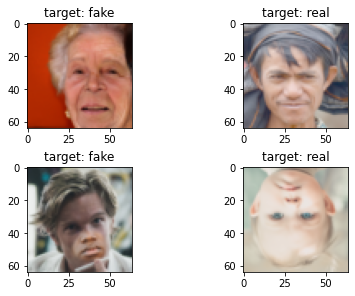

In [15]:
data.show()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data.dataset(split_size=0.05, shuffle=True, random_state=42,
             images_format=torch.float32, labels_format=torch.float32,
             permute=True, one_hot=True, device=device)

Train tensor shape: torch.Size([23837, 3, 64, 64]), torch.Size([23837, 2])
Test tensor shape: torch.Size([627, 3, 64, 64]), torch.Size([627, 2])
Validation tensor shape: torch.Size([628, 3, 64, 64]), torch.Size([628, 2])

Dataset generated successfully :)


In [17]:
class Network(torch.nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.input_norm = torch.nn.BatchNorm2d(3, affine=False)
        self.layer1 = ConvPool(in_features=3, out_features=8)
        self.layer2 = ConvPool(in_features=8, out_features=16)
        self.layer3 = ConvPool(in_features=16, out_features=32)
        self.layer4 = ConvPool(in_features=32, out_features=64)
        self.layer5 = ConvPool(in_features=64, out_features=128)
        self.layer6 = ConvPool(in_features=128, out_features=256)
        
        

        self.net = torch.nn.Sequential(self.layer1, self.layer2, self.layer3, 
                                       self.layer4, self.layer5, self.layer6)
            
        
        self.fc1 = torch.nn.Linear(in_features=256, out_features=128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        
        self.fc2 = torch.nn.Linear(in_features=128, out_features=32)
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.fc3 = torch.nn.Linear(in_features=32, out_features=8)
        self.bn3 = torch.nn.BatchNorm1d(8)

        self.fc4 = torch.nn.Linear(in_features=8, out_features=2)


        self.lin = torch.nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2,
                                       self.fc3, self.bn3, self.fc4)  


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.input_norm(X)
        X = self.net(X)
        X = X.reshape(X.size(0), -1)
        X = self.lin(X)
        X = torch.nn.functional.elu(X, alpha=1.0, inplace=False)
        return X

In [19]:
net = Network()
AntiSpoofClassifier = Model(net, "adam", rmse, device)
AntiSpoofClassifier.train(train_data=(data.train_inputs, data.train_outputs),
                          val_data=(data.val_inputs, data.val_outputs),
                          epochs=10, patience=20, batch_size=100, learning_rate=1.0E-3)

Model initialized succssefully :)

Train loop:

	Epoch: 1/10,  Train Loss: 0.0782,  Val Loss: 0.0703
	Epoch: 2/10,  Train Loss: 0.0644,  Val Loss: 0.0654
	Epoch: 3/10,  Train Loss: 0.0589,  Val Loss: 0.0584
	Epoch: 4/10,  Train Loss: 0.051,  Val Loss: 0.0546
	Epoch: 5/10,  Train Loss: 0.041,  Val Loss: 0.0488
	Epoch: 6/10,  Train Loss: 0.0339,  Val Loss: 0.0495 - No improvement -> Remaining patience: 19
	Epoch: 7/10,  Train Loss: 0.0288,  Val Loss: 0.0418
	Epoch: 8/10,  Train Loss: 0.0259,  Val Loss: 0.0361
	Epoch: 9/10,  Train Loss: 0.0228,  Val Loss: 0.04 - No improvement -> Remaining patience: 19
	Epoch: 10/10,  Train Loss: 0.0207,  Val Loss: 0.0349

Train finished successfully in 407s


In [20]:
AntiSpoofClassifier.evaluate(test_data=(data.test_inputs, data.test_outputs))



Test accuracy:93%
Correct predictions: 583, Wrong predictions: 44


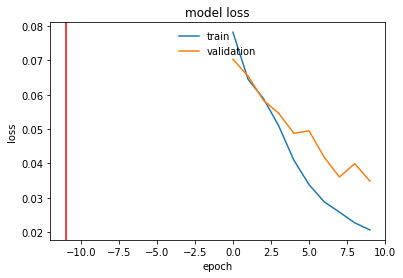


Checkpoint saved successfully :)


In [21]:
AntiSpoofClassifier.plot()
AntiSpoofClassifier.save(path="./", checkpoint_name="module")